In [9]:
# !pip install h5py
#!git clone https://github.com/JVrabel/similarity_metrics.git


# import os

# os.chdir('/content/similarity_metrics/')



FileNotFoundError: [WinError 2] The system cannot find the file specified: '/similarity_metrics/'

In [12]:

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

# Load data

In [1]:
from src.load_libs_data import load_h5_data

spectra, metadata = load_h5_data('datasets/chemcam_extended2015_v_a.h5')
wavelengths = spectra.columns

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [52]:
ground_truth = metadata.loc[:,'SiO2':'K2O']
ground_truth = ground_truth.drop(['FeT', 'FeO', 'Fe2O3'] , axis = 1)
ground_truth = ground_truth.drop(ground_truth.columns[[3]], axis=1)

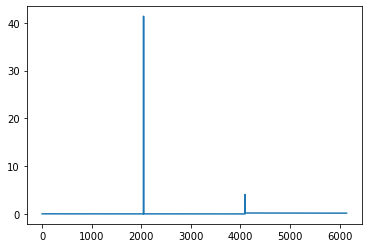

In [53]:
x = wavelengths
differences = [x[i+1]-x[i] for i in range(len(x)-1)]

unique_differences = list(set(differences))
wavelengths
plt.plot(differences)

In [54]:
ech_grid = np.arange(200.00, 1000.00, 0.02)
ech_grid.shape

(40000,)

In [55]:
from scipy.interpolate import interp1d

ech_grid = np.arange(200.00, 1000.00, 0.02)
ech_grid.shape


mask_bound = ~((ech_grid >= wavelengths.min()) & (ech_grid <= wavelengths.max()))
mask_1gap = (ech_grid >= 339) & (ech_grid <= 383)
mask_2gap = (ech_grid >= 468) & (ech_grid <= 474)
mask = mask_bound | mask_1gap | mask_2gap

# mask_plot = 1*mask 
# plt.plot(mask_plot)
ech_grid = ech_grid[~mask]

# interpolate the signal to the new time grid using linear interpolation
f = interp1d(wavelengths, spectra, kind='linear')
spectra_ech = f(ech_grid)

In [ ]:
from src.visualization import plot_spectra

names = ground_truth.index.values.tolist()
plot_spectra(spectra_ech[:20,:], ech_grid)

In [ ]:
from src.preprocess import efficiency_fcn, relu
from src.visualization import plot_one_spectrum

eff = efficiency_fcn(x = ech_grid, x0 = 250, A=1, k=0.008)
eff = relu(eff)
plot_one_spectrum(eff,ech_grid, title = "efficiency")

In [ ]:
corrected_spectra_ech = eff*spectra_ech
plot_spectra(corrected_spectra_ech[:20,:], ech_grid)

# K-means

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.



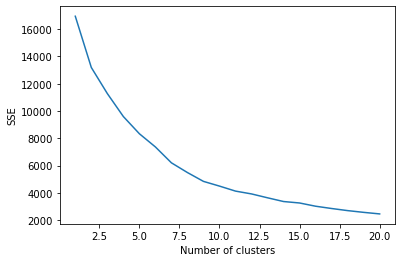

In [59]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# Load data

# Replace NaNs with zeros
data = ground_truth.fillna(0)

# Standardize data
standardized_data = (data - data.mean()) / data.std()



from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Compute SSE for different values of k
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(standardized_data)
    sse.append(kmeans.inertia_)

# Plot SSE vs. number of clusters
plt.plot(range(1, 21), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# PCA of composition

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# Load data

# Replace NaNs with zeros
data = ground_truth.fillna(0)

# Standardize data
standardized_data = (data - data.mean(axis = 0))/ data.std(axis = 0)





# Perform k-means clustering
kmeans = KMeans(n_clusters=11, random_state=42)
labels = kmeans.fit_predict(standardized_data)


# Perform PCA
pca = PCA()
pca.fit(standardized_data)

# Create scores plot
scores = pca.transform(standardized_data)
scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])
scores_df['Cluster'] = labels.astype(str)
scores_fig = px.scatter(scores_df, x='PC1', y='PC2', color='Cluster')

# Create loadings plot
loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'], index=data.columns)
loadings_fig = go.Figure(data=[go.Bar(x=loadings_df.index, y=loadings_df['PC1'])])
loadings_fig.update_layout(xaxis_tickangle=-90)

# Show plots
scores_fig.show()
loadings_fig.show()

# Count the number of samples in each cluster
counts = pd.Series(kmeans.labels_).value_counts()
print(counts)


# Preprocess

In [3]:
!pip install torch

     -------------------------------------- 172.3/172.3 MB 6.0 MB/s eta 0:00:00
     ---------------------------------------- 6.5/6.5 MB 15.9 MB/s eta 0:00:00
     -------------------------------------- 133.1/133.1 kB 8.2 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 16.3 MB/s eta 0:00:00
     ------------------------------------- 536.2/536.2 kB 11.2 MB/s eta 0:00:00


In [3]:
import torch

# torch.cuda.empty_cache()



# np.save("datasets/corrected_chemcam_spectra.npy", corrected_spectra_ech)
# np.save("datasets/ech_grid_reduced.npy", ech_grid)
# np.save("datasets/labels.npy", labels)

import numpy as np

corrected_spectra_ech = np.load("datasets/corrected_chemcam_spectra.npy")
ech_grid = np.load("datasets/ech_grid_reduced.npy")
labels = np.load("datasets/labels.npy")

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corrected_spectra_ech, labels, test_size=0.2, random_state=42, stratify=labels)
# del X, y, samples

In [5]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

if True:
  scaler =  Normalizer(norm = 'max')
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
#

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1506, 30735)
(377, 30735)
(1506,)
(377,)


# Train network

In [7]:
import torch
from torch.utils.data import DataLoader
from src.siamese_net import prepare_triplets, prepare_balanced_triplets

X_train = torch.from_numpy(X_train).unsqueeze(1).float() # Add extra dimension for channels
X_test = torch.from_numpy(X_test).unsqueeze(1).float() # Add extra dimension for channels
y_train = torch.from_numpy(np.array(y_train)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

#X_test_shifted = torch.from_numpy(X_test_shifted).unsqueeze(1).float() # Add extra dimension for channels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train.to(device)
X_test.to(device) 
y_train.to(device)
y_test.to(device)

# Prepare triplets for the training, validation, and test sets
train_triplets = prepare_triplets(X_train, y_train)
val_triplets = prepare_triplets(X_test, y_test)
test_triplets = prepare_triplets(X_test, y_test)



# Create PyTorch DataLoader objects for the training, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_triplets, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_triplets, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_triplets, batch_size=batch_size, shuffle=False)

In [23]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# import funcs
# import importlib
# importlib.reload(funcs)
# from funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# import wandb
from src.siamese_net import SiameseNetwork
import torch.optim as optim
import torch.nn as nn

# Initialize a new WandB run
# wandb.init(project='siamese_net_chemcam', entity='jakubv')

margin = 1.0

# Define the number of epochs and batch size
num_epochs = 1
input_size = X_train.shape[2]
output_size = 10
channels=50
kernel_sizes=[50, 10]
strides=[2, 2]
paddings=[1, 1]
hidden_sizes=[256]
learning_rate = 1e-4


# Instantiate the Siamese network, optimizer, and loss function
#net = SiameseNetwork()
net = SiameseNetwork(input_size=input_size, output_size=output_size, channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings, hidden_sizes=hidden_sizes)
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
criterion = nn.TripletMarginLoss(margin=margin)


net.to(device)
print(net)

# wandb.watch(net)

# # Train the network
# for epoch in range(num_epochs):
#     # Set the network to training mode
#     net.train()

#     # Initialize running loss and number of batches for the training dataset
#     running_loss_train = 0.0
#     num_batches_train = 0

#     # Iterate over the training data loader
#     for i, data in enumerate(train_loader, 0):
#         # Get the inputs and labels for the current batch
#         inputs = [input.to(device) for input in data]
        
#         input_a = inputs[0]
#         input_p = inputs[1]
#         input_n = inputs[2]
        
#         # Compute the embeddings for the current batch
#         outputs = net(input_a, input_p, input_n)


#         # Split the embeddings into anchor, positive, and negative examples
#         anchor = outputs[0]
#         positive = outputs[1]
#         negative = outputs[2]
        
#         # Compute the triplet loss for the current batch
#         loss_train = criterion(anchor, positive, negative)

#         # Backpropagate the loss and update the network parameters
#         loss_train.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         # Update the running loss and number of batches for the training dataset
#         running_loss_train += loss_train.item()
#         num_batches_train += 1

#     # Compute the average loss for the training dataset
#     epoch_loss_train = running_loss_train / num_batches_train

#     # Set the network to evaluation mode
#     net.eval()

#     # Initialize running loss and number of batches for the validation dataset
#     running_loss_val = 0.0
#     num_batches_val = 0

#     # Iterate over the validation data loader
#     for i, data in enumerate(val_loader, 0):
#         # Get the inputs and labels for the current batch
        
#         inputs_val = [input.to(device) for input in data]
        
#         input_a = inputs_val[0]
#         input_p = inputs_val[1]
#         input_n = inputs_val[2]
#         # Compute the embeddings for the current batch
#         outputs = net(input_a, input_p, input_n)

#         # Split the embeddings into anchor, positive, and negative examples
#         anchor = outputs[0]
#         positive = outputs[1]
#         negative = outputs[2]
        
#         # Compute the triplet loss for the current batch
#         loss_val = criterion(anchor, positive, negative)

#         # Update the running loss and number of batches for the validation dataset
#         running_loss_val += loss_val.item()
#         num_batches_val += 1

#     # Compute the average loss for the validation dataset
#     epoch_loss_val = running_loss_val / num_batches_val

#     # Log the loss values to your WandB run
#     # wandb.log({
#     #     "epoch": epoch+1,
#     #     "training_loss": epoch_loss_train, 
#     #     "validation_loss": epoch_loss_val
#     #     })

#     # Print the epoch number, training loss, and validation loss
#     print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss {:.4f}'.format(epoch+1, num_epochs, epoch_loss_train, epoch_loss_val))




# x = torch.randn(1, 1, 30735)
# x = x.to(device)


# #torch.onnx.export(net, (x,x,x), "onnx-ized.onnx", export_params=True)
# # wandb.save('onnx-ized.onnx')
# # End the WandB run
# # wandb.finish()



SiameseNetwork(
  (conv_layers): ModuleList(
    (0): Conv1d(1, 50, kernel_size=(50,), stride=(2,), padding=(1,))
    (1): Conv1d(50, 50, kernel_size=(10,), stride=(2,), padding=(1,))
  )
  (relu_layers): ModuleList(
    (0-1): 2 x ReLU()
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=383450, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
  (relu_fc_layers): ModuleList(
    (0): ReLU()
  )
)


In [25]:
# !pip install netron
# !pip install onnx

import netron

input_dummy = torch.randn(1, 1, 30735)
input_dummy = input_dummy.to(device)


torch.onnx.export(net, (input_dummy,input_dummy,input_dummy), "model.onnx", export_params=False)


input_dummy = torch.randn(1, 1, 30735)
input_dummy = input_dummy.to(device)

netron.start("model.onnx")

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Serving 'model.onnx' at http://localhost:8080


('localhost', 8080)

In [26]:
#!pip install torchinfo

import torchinfo

torchinfo.summary(net, [(1, 1, 30735), (1, 1, 30735), (1, 1, 30735)])

Layer (type:depth-idx)                   Output Shape              Param #
SiameseNetwork                           [1, 10]                   --
├─ModuleList: 1-17                       --                        (recursive)
│    └─Conv1d: 2-1                       [1, 50, 15344]            2,550
├─ModuleList: 1-18                       --                        --
│    └─ReLU: 2-2                         [1, 50, 15344]            --
├─ModuleList: 1-17                       --                        (recursive)
│    └─Conv1d: 2-3                       [1, 50, 7669]             25,050
├─ModuleList: 1-18                       --                        --
│    └─ReLU: 2-4                         [1, 50, 7669]             --
├─ModuleList: 1-21                       --                        (recursive)
│    └─Linear: 2-5                       [1, 256]                  98,163,456
├─ModuleList: 1-20                       --                        --
│    └─ReLU: 2-6                         [1

In [12]:
hidden_sizes = [256,128, 64]
for i in range(len(hidden_sizes)):
    if i == 0:    
        print(input_size)
        print(hidden_sizes[i])
    else:
        print(hidden_sizes[i-1])
        print(hidden_sizes[i])
hidden_sizes[-1]


30735
256
256
128
128
64


64

In [13]:
# from src.siamese_net import SiameseNetwork
# import torch.optim as optim
# import torch.nn as nn

# margin = 1.0

# # Define the number of epochs and batch size
# num_epochs = 10
# input_size = X_train.shape[2]
# output_size = 10
# channels=50
# kernel_sizes=[50, 10]
# strides=[2, 2]
# paddings=[1, 1]
# hidden_sizes=[256, 128]
# learning_rate = 1e-4


# # Instantiate the Siamese network, optimizer, and loss function
# #net = SiameseNetwork()
# net = SiameseNetwork(input_size=input_size, output_size=output_size, channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings, hidden_sizes=hidden_sizes)
# optimizer = optim.Adam(net.parameters(), lr = learning_rate)
# criterion = nn.TripletMarginLoss(margin=margin)


# net.to(device)

# # Train the network
# for epoch in range(num_epochs):
#     # Set the network to training mode
#     net.train()

#     # Initialize running loss and number of batches for the training dataset
#     running_loss_train = 0.0
#     num_batches_train = 0

#     # Iterate over the training data loader
#     for i, data in enumerate(train_loader, 0):
#         # Get the inputs and labels for the current batch
#         inputs = [input.to(device) for input in data]
        
#         input_a = inputs[0]
#         input_p = inputs[1]
#         input_n = inputs[2]
        
#         # Compute the embeddings for the current batch
#         outputs = net(input_a, input_p, input_n)


#         # Split the embeddings into anchor, positive, and negative examples
#         anchor = outputs[0]
#         positive = outputs[1]
#         negative = outputs[2]
        
#         # Compute the triplet loss for the current batch
#         loss_train = criterion(anchor, positive, negative)

#         # Backpropagate the loss and update the network parameters
#         loss_train.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         # Update the running loss and number of batches for the training dataset
#         running_loss_train += loss_train.item()
#         num_batches_train += 1

#     # Compute the average loss for the training dataset
#     epoch_loss_train = running_loss_train / num_batches_train

#     # Set the network to evaluation mode
#     net.eval()

#     # Initialize running loss and number of batches for the validation dataset
#     running_loss_val = 0.0
#     num_batches_val = 0

#     # Iterate over the validation data loader
#     for i, data in enumerate(val_loader, 0):
#         # Get the inputs and labels for the current batch
        
#         inputs_val = [input.to(device) for input in data]
        
#         input_a = inputs_val[0]
#         input_p = inputs_val[1]
#         input_n = inputs_val[2]
#         # Compute the embeddings for the current batch
#         outputs = net(input_a, input_p, input_n)

#         # Split the embeddings into anchor, positive, and negative examples
#         anchor = outputs[0]
#         positive = outputs[1]
#         negative = outputs[2]
        
#         # Compute the triplet loss for the current batch
#         loss_val = criterion(anchor, positive, negative)

#         # Update the running loss and number of batches for the validation dataset
#         running_loss_val += loss_val.item()
#         num_batches_val += 1

#     # Compute the average loss for the validation dataset
#     epoch_loss_val = running_loss_val / num_batches_val

#     # Print the epoch number, training loss, and validation loss
#     print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss {:.4f}'.format(epoch+1, num_epochs, epoch_loss_train, epoch_loss_val))


In [14]:
# # #!pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu117



# import wandb

# wandb.login()



# config = dict(
#     learning_rate = learning_rate,
#     epochs = num_epochs,
#     classes = output_size,
#     kernels = kernel_sizes,
#     hidden_layers = hidden_sizes,
#     batch = batch_size,
#     dataset = "ChemCam",
#     architecture = "Siamese CNN")


# def model_pipeline(hyperparameters):

#     # tell wandb to get started
#     with wandb.init(project="pytorch-demo", config=hyperparameters):
#       # access all HPs through wandb.config, so logging matches execution!
#       config = wandb.config

#       # make the model, data, and optimization problem
#       model, train_loader, test_loader, criterion, optimizer = make(config)
#       print(model)

#       # and use them to train the model
#       train(model, train_loader, criterion, optimizer, config)

#       # and test its final performance
#       test(model, test_loader)

#     return model